## Points Prediction 
- The aim of this model is to try and be able to predict the amount of points a player will score in an upcoming gameweek.
- I want to see if it's possible to get all the players individual game data for the season to train my model as training it on a game by game basis will be much more accurate than over the space of a whole season I think.
- For this I am going to build a seperate python script which can be found in individual/player-data.py

#### Research & Obtaining Data
- I need to try and find a good way to measure this prediction as there isn't a specific target value
- My initial plan was to base it by doing just points but I don't want to do this as thinking about it more, it would just be a total season points tally divided by the amount of games played leaving you with the same amount of points predicted for every week
- I would like to include fixture difficulty in some aspect based off of the formula I created in my fixture analyser
- My current Idea is to see if I can automate going through each players individual FBREF page and getting their game by game statistics, this would give me a much more accurate model as it would actually be basing the model off of a game by game basis rather than the whole season.
- I am going to try this with all of the 24/25 seasons data so far and see if I can make a python script to go through them and retrieve all of the stats.
- I was able to get the first player fine, but they have unique ids in the url which is an issue for automating this process
- I then tried to use an external api that I found here: https://natstat.com/fc
- Unfortunately this was also a dead end as it didn't have nearly enough in depth stats that I need to build this model
- I eventually found a way around the 429 error (too many requests), I had to put a delay of 11 to 15 seconds in between each request, this is to make it seem more natural and so their servers don't shut me out.
- Getting this data took me about 2/3 hours and then I realised I didn't have the player name in the data which was a big part of this for me.
- So I had to run it again and make sure that I was appending the CSV with the players ID from the site and their name so that I can accurately train the model.
- I will have to import goalkeepers seperately as they have a different set of statistics than other players.

#### Pre-Processing & Cleansing Data
- There is going to be a lot of data pre processing and cleansing here as the scraped data is currently extremely messy
- A checklist of what needs to be done to the data is as follows:
    1. Remove games where players didn't play
    2. Remove blank rows
    3. Add headers to the columns
    4. Filter for only Premier League games
    5. Remove unneeded columns.
    6. Add a fantasy points column

In [43]:
import pandas as pd
import numpy as np
import sklearn

df = pd.read_csv('individual/game_by_game_stats.csv')

df = df.dropna()

print(df.head())

         Date  Day     Competition     Matchweek Venue Result         Team  \
0  2024-08-31  Sat  Premier League   Matchweek 3  Away  W 3–2  Bournemouth   
2  2024-09-30  Mon  Premier League   Matchweek 6  Home  W 3–1  Bournemouth   
4  2024-10-26  Sat  Premier League   Matchweek 9  Away  D 1–1  Bournemouth   
5  2024-11-02  Sat  Premier League  Matchweek 10  Home  W 2–1  Bournemouth   
6  2024-11-09  Sat  Premier League  Matchweek 11  Away  L 2–3  Bournemouth   

          Opponent Started                             Position  ...  \
0          Everton       N  On matchday squad, but did not play  ...   
2      Southampton       N  On matchday squad, but did not play  ...   
4      Aston Villa       N  On matchday squad, but did not play  ...   
5  Manchester City       N  On matchday squad, but did not play  ...   
6        Brentford       N  On matchday squad, but did not play  ...   

                      Attempted-Passes                      Pass-Percentage  \
0  On matchday squa

This is just simply reading in the csv, dropping the Nan values and printing the head to make sure it imported ok.

In [11]:
dfGK = df[df['Position'] == "GK"]


dfGK.to_csv('filtered_game_by_game_stats_GK.csv', index=False)

In [44]:
df = df[df['Position'] != "On matchday squad, but did not play"]

df = df[df['Competition'] == "Premier League"]

df = df.drop(columns=['Competition', 'Matchweek', 'Day', 'Match-Report', 'PlayerID'])

df.to_csv('filtered_game_by_game_stats.csv', index=False)


In [ ]:
dfGK = pd.read_csv('filtered_game_by_game_stats_GK.csv')

dfGK = dfGK[dfGK['Position'] != "On matchday squad, but did not play"]

dfGK = dfGK[dfGK['Competition'] == "Premier League"]

dfGK = dfGK.drop(columns=['Competition', 'Matchweek', 'Date', 'Day', 'Venue', 'Match-Report', 'PlayerID'])

dfGK.to_csv('filtered_game_by_game_stats_GK.csv', index=False)

This block here is doing three primary things, it's removing games where players didn't make an appearance, it is making sure it's just Premier League data that we are working with adn then finally it's dropping the unneeded columns.

The next step is to add the fantasy points column.

In [45]:
df['Clean-Sheet'] = np.where(
    (df['Venue'] == 'Home') & (df['Result'].str[4] == '0'),
    1,
    0
)

df.to_csv('filtered_game_by_game_stats.csv', index=False)

I had to get some help from chatgpt to structure this as a normal if statement wasn't working for some reason, this adds a clean sheet for the outfield players

Now I have all of the stats that I need I can start calculating the fantasy points for each player based off of their position.

In [46]:
df['Position'] = df['Position'].str[:2]

defender_list = ['CB', 'LB', 'RB', 'WB', 'DF']
midfielder_list = ['CM', 'DM', 'AM', 'RM', 'LM', 'MF']
forward_list = ['ST', 'LW', 'RW', 'FW']

conditions = [
    df['Position'].isin(defender_list),
    df['Position'].isin(midfielder_list),
    df['Position'].isin(forward_list)
]

choices = ['Defender', 'Midfielder', 'Forward']

df['Position'] = np.select(conditions, choices, default='Goalkeeper')

df = df[df['Position'] != 'Goalkeeper']

df.to_csv('filtered_game_by_game_stats.csv', index=False)


In this code block I am filtering the positions down to a single position per player because their main position is always listed first in the data and then I am converting it to one of 3 categories for easiness when I'm building the model later on. 

I am also dropping the goalkeepers from this because I am storing them in a seperate CSV file where their stats are correctly inputted.

Now I will be moving on to calculating the fantasy points based off of their category.

In [47]:
cols_to_convert = ['Goals', 'Assists', 'Clean-Sheet', 'Ycard', 'Rcard']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce').fillna(0)
# ChatGPT gave me this code to convert the columns to numeric values as I was having trouble converting them to integers

conditions = [
    df['Position'] == 'Defender',
    df['Position'] == 'Midfielder',
    df['Position'] == 'Forward'
]

choices = [
    df['Goals'] * 5 + df['Assists'] * 3 + df['Clean-Sheet'] * 4 + df['Ycard'] * -1 + df['Rcard'] * -3,
    df['Goals'] * 5 + df['Assists'] * 3 + df['Clean-Sheet'] * 1 + df['Ycard'] * -1 + df['Rcard'] * -3,
    df['Goals'] * 5 + df['Assists'] * 3 + df['Ycard'] * -1 + df['Rcard'] * -3
]

df['Fantasy-Points'] = np.select(conditions, choices, default=0)

df.to_csv('filtered_game_by_game_stats.csv', index=False)


This is the logic that I am using for calculating the outfield players and it works as follows:

Defenders:
    - 5 points for a goal
    - 3 points for an assist
    - 4 points for keeping a clean sheet
    - minus 1 for a yellow card
    - minus 3 for a red card

Midfielders:
    - 5 points for a goal
    - 3 points for an assist
    - 1 point for keeping a clean sheet
    - minus 1 for a yellow card
    - minus 3 for a red card

Attackers:
    - 5 points for a goal
    - 3 points for an assist
    - minus 1 for a yellow card
    - minus 3 for a red card


This is the standard breakdown for points in fantasy football, it may look like the attackers will have less points but it evens out because they are scoring a lot more than the rest.

Now I am going to replicate this for the Goalkeeper points.

In [40]:
dfGK['fantasy-points'] = (dfGK['SoTA'] * 1 + dfGK['CS'] * 5 + dfGK['GA'] * -2)


dfGK.to_csv('filtered_game_by_game_stats_GK.csv', index=False)

This is the formula that I have used for keepers, usually keepers aren't rewarded for saves but I think they should be as it is a crucial aspect of their game that goes unrecognised, I also believe there should be a penalty for goals conceeded as this is also their main job.

Now that we have the data we can start to build the model for this feature. I am going to start by doing the outfield models first and then we can work on the goalkeeper one after.

In [48]:
from sklearn.preprocessing import LabelEncoder

team_encoder = LabelEncoder()
df['TeamID'] = team_encoder.fit_transform(df['Team'])

player_encoder = LabelEncoder()
df['Player-Code'] = player_encoder.fit_transform(df['Player-Name'])

oppo_encoder = LabelEncoder()
df['OpponentID'] = oppo_encoder.fit_transform(df['Opponent'])

venue_encoder = LabelEncoder()
df['VenueID'] = venue_encoder.fit_transform(df['Venue'])

started_encoder = LabelEncoder()
df['StartedID'] = started_encoder.fit_transform(df['Started'])

df.to_csv('filtered_game_by_game_stats.csv', index=False)


I am just adding a label encoder here so that I can include team and players in the model's training

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

# Att_X = df[['xG', 'npxG', 'xAG', 'Ycard', 'Rcard', 'TeamID', 'OpponentID', 'Player-Code']]
Att_y = df['Venue', 'TeamID', 'OpponentID', 'Player-Code', '']
Att_y = df['Fantasy-Points']

X_train, X_test, y_train, y_test = train_test_split(Att_X, Att_y, test_size=0.2, random_state=42)


These are the values that I want to try first as it encapsulates the main fields that I think would be vital in predicting an attackers points.

In [47]:
ATT_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ATT_RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")


MAE: 1.10


MAE works by giving you the average amount that the model is off by 1.1 point from what the actual value is which for a model like this is a good level of accuracy.

I was going to also use R2 score for this but in the end I decided against it as it is very hard to capture all aspects of what affects the result of a football game so it doesn't represent the level of the model.

In [ ]:
sample_data = {
    "xG": [0.8],
    "npxG": [0.8],
    "xAG": [0.1],
    "Ycard": [0],
    "Rcard": [0],
    "TeamID" : [11],
    "OpponentID" : [15],
    "Player-Code" : [326]
}

sample_df = pd.DataFrame(sample_data)

y_pred_sample = ATT_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])


Predicted points for this game 4.076805575956457


This is a test I wanted to run to get a level of accuracy for the model. The data that I used here is Salah's data from when they played Nottingham Forrest last season, I wanted to see how accurate the model was compared to a game where I could see what he got last year. This is by no means a perfect test due to form as Forrest are a lot better this season but the model predicted him getting 4 points and last year in my system he would have got 5. I think this is a good prediction as 1 point off of the actual amount is a great prediction for the model.

I now want to replicate this with midfielders, defenders and goalkeepers.

In [65]:
Mid_X = df[['xG', 'npxG', 'xAG', 'Ycard', 'Rcard', 'TeamID', 'OpponentID', 'Player-Code', 'Clean-Sheet']]
Mid_y = df['Fantasy-Points']

MidX_train, MidX_test, Midy_train, Midy_test = train_test_split(Mid_X, Mid_y, test_size=0.2, random_state=42)

In [66]:
MID_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
MID_RF.fit(MidX_train, Midy_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [67]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.10


In [74]:
sample_data = {
    "xG": [1.2],
    "npxG": [0.4],
    "xAG": [1.0],
    "Ycard": [1],
    "Rcard": [0],
    "TeamID" : [13],
    "OpponentID" : [15],
    "Player-Code" : [54],
    "Clean-Sheet": [0]
}
# Mid_X = df[['xG', 'npxG', 'xAG', 'Ycard', 'Rcard', 'TeamID', 'OpponentID', 'Player-Code', 'Clean-Sheet']]
sample_df = pd.DataFrame(sample_data)

y_pred_sample = MID_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])

Predicted points for this game 8.67026862026862


For this one I wanted to follow a similar test that I did for the attacker model so for this I used Bruno Fernandes' stats vs Nottingham Forest last season. I wanted to try a game this time where he would have had a bigger haul of points as in this game he actually got a goal and an assist. This leaves him at 8 points in my model due to not having a clean sheet in the game, this prediction of 8.6 is very good for a prediction like this as nothing is guaranteed in football.

Next I will replicate this with the defenders.

In [75]:
Def_X = df[['xG', 'npxG', 'xAG', 'Ycard', 'Rcard', 'TeamID', 'OpponentID', 'Player-Code', 'Clean-Sheet']]
Def_y = df['Fantasy-Points']

DefX_train, DefX_test, Defy_train, Defy_test = train_test_split(Def_X, Def_y, test_size=0.2, random_state=42)

In [76]:
DEF_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
DEF_RF.fit(DefX_train, Defy_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [77]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.10


In [84]:
sample_data = {
    "xG": [0.0],
    "npxG": [0.0],
    "xAG": [0.0],
    "Ycard": [0],
    "Rcard": [0],
    "TeamID" : [11],
    "OpponentID" : [7],
    "Player-Code" : [447],
    "Clean-Sheet": [1]
}
sample_df = pd.DataFrame(sample_data)

y_pred_sample = DEF_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])

Predicted points for this game 3.5882235462613226


Once again I am using the same type of testing and in this instance I am using Virgil Van Dijk vs Everton from last season. In this game according to my model Van Dijk would have actually scored 4 points as he didn't get a goal or an assist but Liverpool did keep a clean sheet in this game, the model predicted this at 3.5 points for the game which once again is a great prediction for the model to be within 0.5 of the result.

### Issue

I have realised that I have structured these incorrectly as for a prediction I shouldn't be going by game data because I wont have that for the upcoming games so I need to go for stuff like the player, the opponent, the team theyre on, form, venue etc. I will have to do a bit more data pre processing to add these in so this will be my next step below.

In [55]:
df = pd.read_csv('filtered_game_by_game_stats.csv')
table = pd.read_csv('filtered_table.csv')

# Rename for clarity before merging
table = table[['Squad', 'Form_Rating']]

# Merge for Team's form rating
df = df.merge(
    table.rename(columns={'Squad': 'Team', 'Form_Rating': 'Team_Form_Rating'}),
    on='Team',
    how='left'
)

# Merge for Opponent's form rating
df = df.merge(
    table.rename(columns={'Squad': 'Opponent', 'Form_Rating': 'Opponent_Form_Rating'}),
    on='Opponent',
    how='left'
)



df.to_csv('filtered_game_by_game_stats.csv', index=False)

I had to get some help on how to transfer over some of the data from my other csv to my current one from ChatGPT and a really useful GeeksForGeeks article that I found here: https://www.geeksforgeeks.org/python-pandas-merging-joining-and-concatenating/

Now I am going to redo the model and see how accurate I can get it

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

Att_X = df[['VenueID', 'TeamID', 'OpponentID', 'Player-Code', 'Team_Form_Rating', 'Opponent_Form_Rating', 'StartedID']]
Att_y = df[['Fantasy-Points']]

X_train, X_test, y_train, y_test = train_test_split(Att_X, Att_y, test_size=0.2, random_state=42)

In [24]:
ATT_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ATT_RF.fit(X_train, y_train)

y_pred = ATT_RF.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [26]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.34


In [33]:
sample_data = {
    "VenueID": [1],
    "TeamID" : [11],
    "OpponentID" : [16],
    "Player-Code" : [326],
    "Team_Form_Rating": [12],
    "Opponent_Form_Rating": [0],
    "StartedID": [1],
}

sample_df = pd.DataFrame(sample_data)

y_pred_sample = ATT_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])

Predicted points for this game 2.5761297411749227


This seemed like a very low amount for a prediction of Salah at home to Southampton who are on awful form so i wanted to see if there was something making the dataset bias.

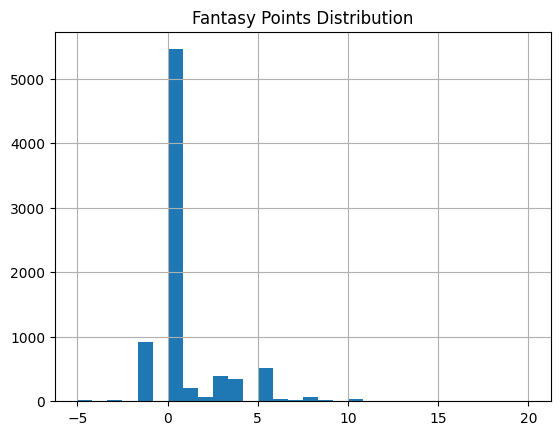

In [34]:
import matplotlib.pyplot as plt

df['Fantasy-Points'].hist(bins=30)
plt.title("Fantasy Points Distribution")
plt.show()


As can be seen here the proportion of 0 points is massive which needs to be rectified, I think this is because of a lot of sub appearances where they are getting less than 10 minutes and not making an impact but it is being given the same weight as full 90 minute performances so I am going to remove them if they played 10 minutes or less.

In [57]:
df = df[df['Minutes-Played'] >= 10]

Att_X = df[['VenueID', 'TeamID', 'OpponentID', 'Player-Code', 'Team_Form_Rating', 'Opponent_Form_Rating', 'StartedID']]
Att_y = df[['Fantasy-Points']]

X_train, X_test, y_train, y_test = train_test_split(Att_X, Att_y, test_size=0.2, random_state=42)


In [36]:
ATT_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ATT_RF.fit(X_train, y_train)

y_pred = ATT_RF.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [37]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.47


In [41]:
sample_data = {
    "VenueID": [1],
    "TeamID" : [11],
    "OpponentID" : [2],
    "Player-Code" : [326],
    "Team_Form_Rating": [12],
    "Opponent_Form_Rating": [3],
    "StartedID": [1],
}

sample_df = pd.DataFrame(sample_data)

y_pred_sample = ATT_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])

Predicted points for this game 2.2176663754129065


This is better but I have nothing to indicate a players current form, I want to create a column similar to the team form but for the player based off of their last few games with key information about them such as goals, assists, clean-sheets etc.

In [83]:
rolling_window = 5

df['Player_Goals_Form'] = df.groupby('Player-Name')['Goals'].shift(1).rolling(rolling_window).mean()
df['Player_Assists_Form'] = df.groupby('Player-Name')['Assists'].shift(1).rolling(rolling_window).mean()
df['Player_Minutes_Form'] = df.groupby('Player-Name')['Minutes-Played'].shift(1).rolling(rolling_window).mean()
df['Player_Ycard_Form'] = df.groupby('Player-Name')['Ycard'].shift(1).rolling(rolling_window).mean()
df['Player_Rcard_Form'] = df.groupby('Player-Name')['Rcard'].shift(1).rolling(rolling_window).mean()
df['Player_Clean_Sheet_Form'] = df.groupby('Player-Name')['Clean-Sheet'].shift(1).rolling(rolling_window).mean()
df['Player_FP_Form'] = df.groupby('Player-Name')['Fantasy-Points'].shift(1).rolling(rolling_window).mean()

df.to_csv('filtered_game_by_game_stats.csv', index=False)

I orignally tried to figure out a way to put all of this information into a single column but I was having a lot of hassle so I asked ChatGPT if there was a simpler and more efficient way of doing this and it provided me with this, this is a much better way of me doing it as I can pick and choose the metrics that I want to include for each positions model.

Now that I have this I can once again start building the model again.

In [73]:
df['Minutes-Played'] = pd.to_numeric(df['Minutes-Played'], errors='coerce')

df = df[df['Minutes-Played'] >= 10]

Att_X = df[['VenueID', 'TeamID', 'OpponentID', 'Player-Code', 'Team_Form_Rating', 'Opponent_Form_Rating', 'StartedID', 'Player_Goals_Form', 'Player_Assists_Form', 'Player_Ycard_Form', 'Player_Rcard_Form', 'Player_FP_Form']]
Att_y = df[['Fantasy-Points']]

X_train, X_test, y_train, y_test = train_test_split(Att_X, Att_y, test_size=0.2, random_state=42)


In [74]:
ATT_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ATT_RF.fit(X_train, y_train)

y_pred = ATT_RF.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [75]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.45


In [81]:
sample_data = {
    "VenueID": [1],
    "TeamID" : [11],
    "OpponentID" : [7],
    "Player-Code" : [326],
    "Team_Form_Rating": [6],
    "Opponent_Form_Rating": [3],
    "StartedID": [1],
    "Player_Goals_Form": [0.8],
    "Player_Assists_Form": [0.1],
    "Player_Ycard_Form": [0],
    "Player_Rcard_Form": [0],
    "Player_FP_Form": [4.4],
}

sample_df = pd.DataFrame(sample_data)

y_pred_sample = ATT_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])

Predicted points for this game 3.94086034062961


I am now much happier with the metrics that are being used to make these predictions and they are performing way more towards where I would expect them to be, in the example given it is Mohammed Salah vs Everton at home last season. In this game last year he achieved 4 points with one goal, so this is a very good prediction rating for a game like this.

I am now going to replicate with midfielders, defenders and goalkeepers.

In [84]:
df['Minutes-Played'] = pd.to_numeric(df['Minutes-Played'], errors='coerce')

df = df[df['Minutes-Played'] >= 10]

Mid_X = df[['VenueID', 'TeamID', 'OpponentID', 'Player-Code', 'Team_Form_Rating', 'Opponent_Form_Rating', 'StartedID', 'Player_Goals_Form', 'Player_Assists_Form', 'Player_Clean_Sheet_Form', 'Player_Ycard_Form', 'Player_Rcard_Form', 'Player_FP_Form']]
Mid_y = df[['Fantasy-Points']]

X_train, X_test, y_train, y_test = train_test_split(Mid_X, Mid_y, test_size=0.2, random_state=42)


In [85]:
Mid_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
Mid_RF.fit(X_train, y_train)

y_pred = Mid_RF.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [86]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.45


In [90]:
sample_data = {
    "VenueID": [1],
    "TeamID" : [18],
    "OpponentID" : [19],
    "Player-Code" : [82],
    "Team_Form_Rating": [10],
    "Opponent_Form_Rating": [2],
    "StartedID": [1],
    "Player_Goals_Form": [0.6],
    "Player_Assists_Form": [0.2],
    "Player_Clean_Sheet_Form": [0.2],
    "Player_Ycard_Form": [0],
    "Player_Rcard_Form": [0],
    "Player_FP_Form": [3],
}

sample_df = pd.DataFrame(sample_data)

y_pred_sample = Mid_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])

Predicted points for this game 3.3321233477403087


This one here is for Cole Palmer vs Wolves last season at home where he achieved 4 points, this is a good prediction as it is within one of his actual tally for the game. 

Now the next step is to move on to defenders and see how they are performing

In [91]:
df['Minutes-Played'] = pd.to_numeric(df['Minutes-Played'], errors='coerce')

df = df[df['Minutes-Played'] >= 10]

Def_X = df[['VenueID', 'TeamID', 'OpponentID', 'Player-Code', 'Team_Form_Rating', 'Opponent_Form_Rating', 'StartedID', 'Player_Goals_Form', 'Player_Assists_Form', 'Player_Clean_Sheet_Form', 'Player_Ycard_Form', 'Player_Rcard_Form', 'Player_FP_Form']]
Def_y = df[['Fantasy-Points']]

X_train, X_test, y_train, y_test = train_test_split(Def_X, Def_y, test_size=0.2, random_state=42)

In [92]:
Def_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
Def_RF.fit(X_train, y_train)

y_pred = Def_RF.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [93]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1.45


In [ ]:
sample_data = {
    "VenueID": [1],
    "TeamID" : [11],
    "OpponentID" : [12],
    "Player-Code" : [447],
    "Team_Form_Rating": [12],
    "Opponent_Form_Rating": [12],
    "StartedID": [1],
    "Player_Goals_Form": [0.2],
    "Player_Assists_Form": [0.0],
    "Player_Clean_Sheet_Form": [0.6],
    "Player_Ycard_Form": [0],
    "Player_Rcard_Form": [0],
    "Player_FP_Form": [4],
}

sample_df = pd.DataFrame(sample_data)

y_pred_sample = Def_RF.predict(sample_df)

print("Predicted points for this game", y_pred_sample[0])